In [1]:
data_partition = {
        "gwilliams2023": {
            "testing_subjects": [19, 20, 21],
            "testing_tasks": [0],
        }
        # "schoffelen2022": {
        #     "testing_subjects": [],
        #     "testing_tasks": [8, 9],
        # },
}

In [2]:
# from utils.compression import compress_directories, decompress_directories

# for base_path, batch_type in data_partition.items():
#     decompress_directories(
#         source_path=f'downloaded_data/{base_path}',
#         destination_path=f'data/{destination_path}',
#         checksum_file_name="checksums.txt",
#         delete_compressed_files=True,
#         num_workers=None
#     )

In [ ]:
from config import SimpleConvConfig
from models.simpleconv import SimpleConv
import torch

model_config = SimpleConvConfig(
    # Str to list of possible conditions
    conditions=None,
    # Channels
    in_channels=208,
    out_channels=128,
    hidden_dim=256,
    dropout=0.2,
    # Sensor layout settings
    layout_dim=2,
    layout_proj=False,
    layout_scaling="minmax",
    # Merger with spatial attn
    merger=False,
    merger_emb_dim=0,
    merger_channels=0,
    merger_dropout=0.0,
    merger_conditional=None,
    # Inital
    initial_linear=256,
    initial_depth=1,
    # Conditional layers
    conditional_layers=False,
    conditional_layers_dim=None,  # input or hidden_dim
    # Conv layer overall structure
    depth=4,
    kernel_size=3,
    growth=1.0,
    dilation_growth=2,
    dilation_period=5,
    glu=1,
    conv_dropout=0.2,
    dropout_input=0.2,
    batch_norm=True,
    # Quantizer
    quantizer=False,
    num_codebooks=0,
    codebook_size=0,
    quantizer_commitment=0,
    quantizer_temp_init=0,
    quantizer_temp_min=0,
    quantizer_temp_decay=0,
    # Transformers Encoders
    transformer_input=None,
    transformer_encoder_emb=None,
    transformer_encoder_layers=0,
    transformer_encoder_heads=0,
    # Transformer Decoders
    transformer_decoder_emb=None,
    transformer_decoder_layers=0,
    transformer_decoder_heads=0,
    transformer_decoder_dim=0,
)

In [4]:
from train.training_session_v0 import TrainingSessionV0
from config import TrainingConfigV0
import multiprocessing

config = TrainingConfigV0(
    brain_encoder_config=model_config,
    data_partition=data_partition,
    # Pre-processing parameters
    # Brain
    new_freq=100,
    frequency_bands={'all': (None, None)},
    max_random_shift=0.2,
    window_size= 4,
    window_stride=1,
    brain_clipping=False,
    baseline_window=False,
    notch_filter=False,
    scaling='both',
    # Hyperparameters
    learning_rate = 3e-4,
    weight_decay = 1e-4,
    epochs = 50,
    batch_size = 256,
    use_clip_loss = True,
    use_mse_loss = False,
    alpha = 0.0,
    random_test_size = 10,
    seed = 42,
)

session = TrainingSessionV0(
    config=config,
    studies={"gwilliams2023": 'audio'},
    data_path='data',
    save_path='saves/Dec16_CLIP',
    clear_cache=False,
)

Loading Gwilliams2023 with batch type audio
Data partitioned on studies ['gwilliams2023'].
Train: 135, Unseen Task: 12, Unseen Subject: 45, Unseen Both: 4.

SimpleConv initialized with 2614656 parameters, cond: []
Merger False, merger channels 0
ConvBlocks: 4, hidden_dim: 256, params 2363904


In [ ]:
try:
    session.train(
        device='cuda',
        buffer_size=30,
        num_workers=multiprocessing.cpu_count() - 2,
        max_cache_size=200,
        current_epoch=0,
    )
except KeyboardInterrupt as e:
    session.dataloader.stop()
    print('Exited')

2024-12-16 13:28:27,043	INFO worker.py:1821 -- Started a local Ray instance.
Training Epoch 1: 100%|██████████| 135/135 [03:29<00:00,  1.55s/it]


Epoch 1 completed in 3.49m. 0.03m per recording.
Testing at epoch 1


In [ ]:
from train.training_session_v0 import load_training_session
import multiprocessing
import torch

session = load_training_session(
    save_path='saves/Dec16_CLIP/epoch_2',
    studies={"gwilliams2023": 'audio'},
    data_path='data',
)

dataloader = session.get_dataloader(buffer_size=1, num_workers=multiprocessing.cpu_count() - 2, max_cache_size=100)

dataloader.start_fetching(
    recordings=[
        session.recordings[15]
    ]
)

batch = dataloader.get_recording()
brain, audio, recording = batch.brain_segments['all'], batch.audio_segments, batch.recording

with torch.no_grad():
    pred, _ = session.model(x=brain, recording=recording, train=False)
    
dataloader.stop()

Loading Gwilliams2023 with batch type audio
Data partitioned on studies ['gwilliams2023'].
Train: 135, Unseen Task: 12, Unseen Subject: 45, Unseen Both: 4.

SimpleConv initialized with 2614656 parameters, cond: []
Merger False, merger channels 0
ConvBlocks: 4, hidden_dim: 256, params 2363904


2024-12-16 13:09:20,651	INFO worker.py:1821 -- Started a local Ray instance.


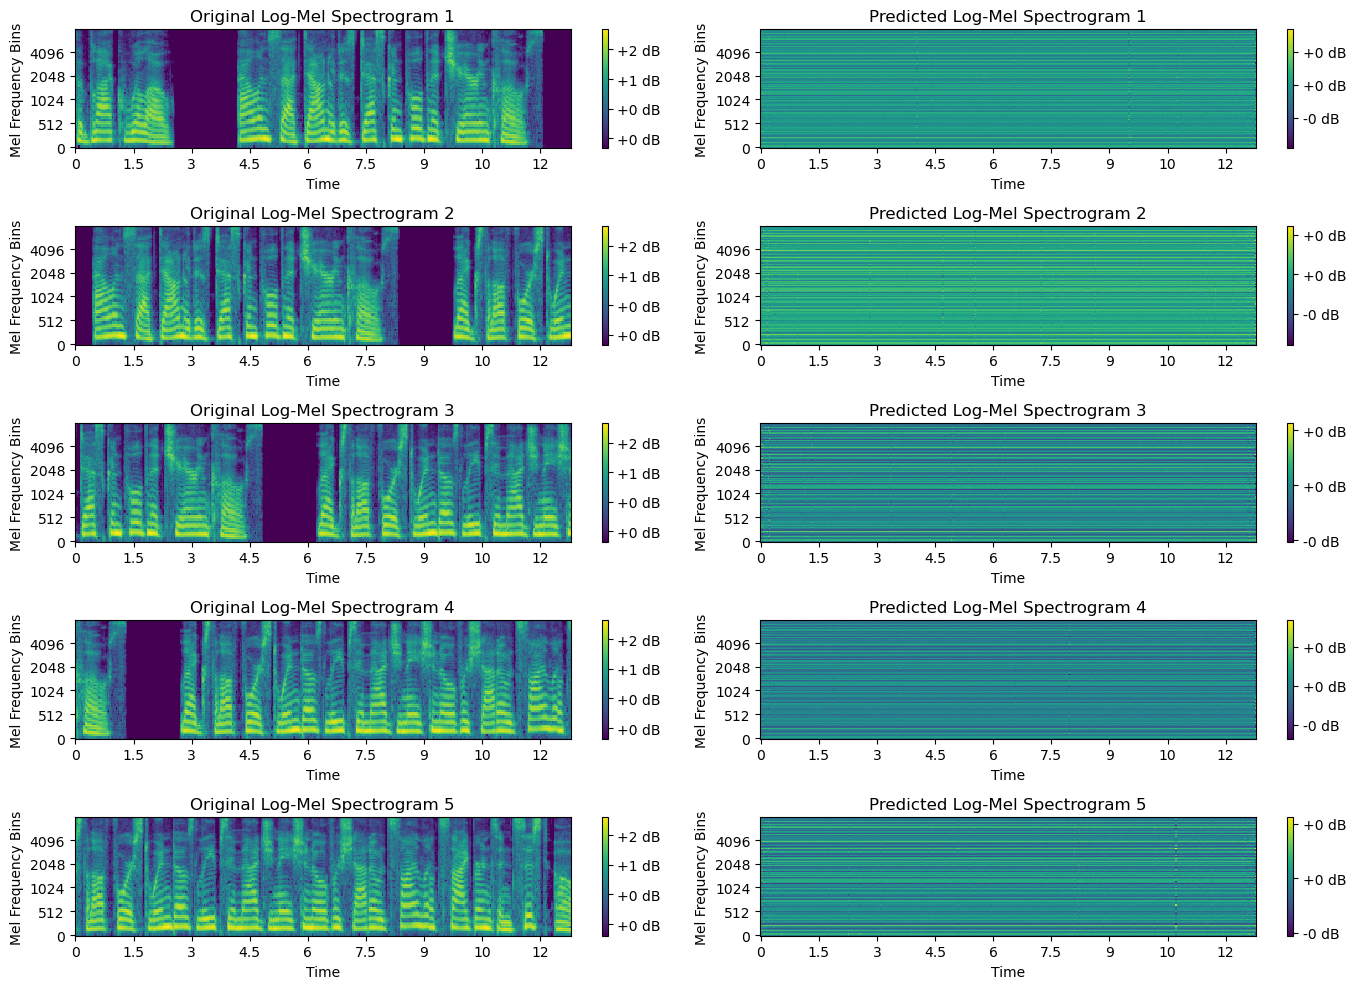

In [2]:
from utils.plot import mel_spectrogram

mel_spectrogram(
    x=audio,
    max_plots=5,
    x_pred=pred,
)